# APS1070
#### Anomaly Detection - Project 2



Project 2 has two parts: a tutorial component (which will be covered in labs) and an exercises component (to be completed as homework, individually). Overall, this project is worth 12.5% of your final grade. Completing the tutorial section is worth 2.5 marks. The exercises section will be graded out of the remaining 10 marks.


Please fill out the following:


*   Your **name**: Zhang Qian
*   Your **student number**: 1000062736



## Tutorial

In this part of the assignment, we will implement an anomaly detection algorithm using the Gaussian model to detect anomalous behavior in a 2D dataset first and then a high-dimensional dataset.

Loading relevant libraries and the dataset

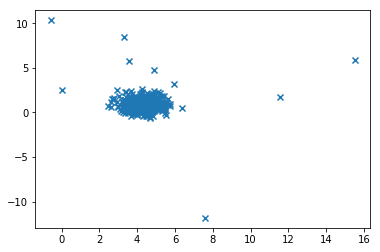

In [0]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=1,
                       cluster_std=0.60, random_state=0)
X_append, y_true_append = make_blobs(n_samples=10,centers=1,
                                    cluster_std=5,random_state=0)
X = np.vstack([X,X_append])
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting
plt.scatter(X[:,0],X[:,1],marker="x");

Here we've manufactured a dataset where some points are visibly outliers from the main distribution.

We can see this from looking at the plot, but how do we robustly identify the outliers? 

That's where a Gaussian estimation comes in. For this dataset, we only need a single Gaussian, for which we are gonna calculate the mean and standard deviation. Then, we're able to find the points that don't seem likely to have originated from that distribution - these are our outliers!

First, we need to calculate the mean and variance for our data. Complete the function below to generate these values using these formulae:

$$\mu = \frac{1}{m} \sum_{i=1}^{m}X_i$$

$$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m}(X_i-\mu)^2$$

In [0]:
def estimateGaussian(X):
    """
     This function provides an estimate of mean and variance 
     of a Gaussian distribution along multiple dimensions
     using X, an N-dimensional vector
    """
    
    m = X.shape[0]
    
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = 1/m*sum_
    
    # compute variance of X
    var = 1/m * np.sum((X-mu)**2,axis=0)
    
    return mu,var
mu, sigma = estimateGaussian(X)
  

Now, we will calculate for each point in X, the probability of the distribution $N(\mu,\sigma^2)$ generating that point randomly. This has been completed for you, although it is important to understand how the calculation of the PDF works.

In [0]:
def multivariateGaussian(X, mu, sigma):
    """
    This function computes the probability density function of a multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p
p = multivariateGaussian(X, mu, sigma)

Now that we have the probability of each point in the dataset, we can plot these on the original scatterplot:

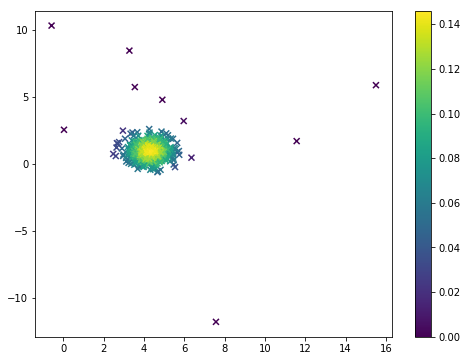

In [0]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();

We're getting closer to the point where we can programatically identify our outliers for a single Gaussian distribution. The last step is to identify a value for $p$, below which we consider a point to be an outlier. We term this $\epsilon$.

In [0]:
#Choose a value for epsilon

epsilon = 0.01

Now we'll highlight on the scatter plot all points that are below $\epsilon$:

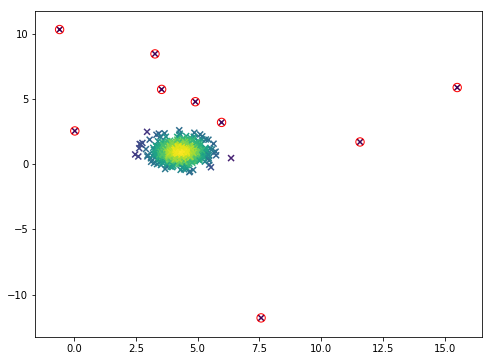

In [0]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

How well did your epsilon value do? Play around with different values until you're happy with the plot above. 

With an epsilon value of 0.01, the major outliers are captured. 

We can additionally look at our model's classification performance another way. By sorting the points ascending by their probability, and classifying the first $k$ points as anomalous, we can determine the model's precision@k. Implement this in the cell below. 

* What is the highest value of K for which we get precision of 1.0? 

k=10
* What is the precision for K=4? 

precision = 1.0

In [0]:
from sklearn.metrics import precision_score

for i in range(0,15):
     mn = sorted(p)[i]
     sc = precision_score( y_true,1*(p<=mn))
     print('K is ',i+1, ', precision is', sc)


K is  1 , precision is 1.0
K is  2 , precision is 1.0
K is  3 , precision is 1.0
K is  4 , precision is 1.0
K is  5 , precision is 1.0
K is  6 , precision is 1.0
K is  7 , precision is 1.0
K is  8 , precision is 1.0
K is  9 , precision is 1.0
K is  10 , precision is 1.0
K is  11 , precision is 0.9090909090909091
K is  12 , precision is 0.8333333333333334
K is  13 , precision is 0.7692307692307693
K is  14 , precision is 0.7142857142857143
K is  15 , precision is 0.6666666666666666


You may have noticed that in this example, we are training and testing on the _entire_ dataset. This is absolutely not standard practice! You should _always_ split into a training and testing set. However, the reason that we can get away with this here is because we don't actually use labels at all during training - this is an _unsupervised_ machine learning task. Unsupervised learning methods are beneficial for anomaly detection because in the real world (i.e. testing!) we might come across types of outliers that we didn't see during training. We want to use a method that can handle this, and unsupervised methods are often better suited to this type of domain.

For the next section, we'll move to Mixture of Gaussian models. Take a look at the following dataset:

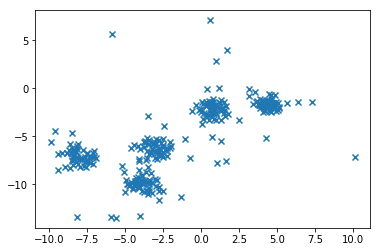

In [0]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
X, y_true = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5,
                                    cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=1, shuffle=True)

plt.scatter(X_train[:,0],X_train[:,1],marker="x");

Okay, we have more than one cluster centre now. So what? Let's just ignore that and use the same model as before. 

* What is the precision for k=1 in the cell below?

Precision = 1.0
* k=10? 

Precision = 0.9
* k=100? 

Precision = 0.13

K is  1 , precision is 1.0
K is  2 , precision is 1.0
K is  3 , precision is 1.0
K is  4 , precision is 1.0
K is  5 , precision is 1.0
K is  6 , precision is 1.0
K is  7 , precision is 1.0
K is  8 , precision is 1.0
K is  9 , precision is 1.0
K is  10 , precision is 0.9
K is  11 , precision is 0.8181818181818182
K is  12 , precision is 0.75
K is  13 , precision is 0.7692307692307693
K is  14 , precision is 0.7857142857142857
K is  15 , precision is 0.7333333333333333
K is  16 , precision is 0.6875
K is  17 , precision is 0.6470588235294118
K is  18 , precision is 0.6111111111111112
K is  19 , precision is 0.5789473684210527
K is  20 , precision is 0.55
K is  21 , precision is 0.5238095238095238
K is  22 , precision is 0.5
K is  23 , precision is 0.4782608695652174
K is  24 , precision is 0.4583333333333333
K is  25 , precision is 0.44
K is  26 , precision is 0.4230769230769231
K is  27 , precision is 0.4074074074074074
K is  28 , precision is 0.39285714285714285
K is  29 , precision is

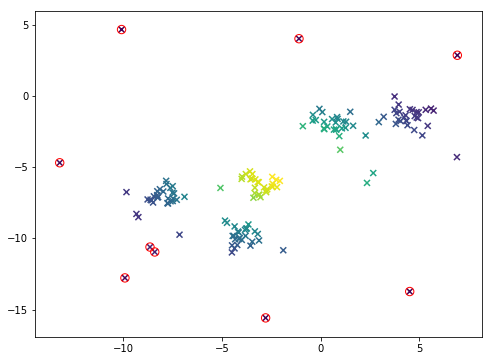

In [0]:
mu, sigma = estimateGaussian(X_train)
p = multivariateGaussian(X_test, mu, sigma)
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

from sklearn.metrics import precision_score

for i in range(0,100):
     mn = sorted(p)[i]
     sc = precision_score(y_test,1*(p<=mn))
     print('K is ',i+1, ', precision is', sc)

Uh oh. This model performs terribly. It's fit the mean to a section of space where we don't have _any_ points, and it has absolutely no idea which points are outliers! This was probably pretty obvious to you though. We need to move to a Mixture of Gaussians model - one in which we use multiple Gaussians to fit the data. We'll use `sklearn.mixture.GaussianMixture` to do this - or rather you will! Use the documentation, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) to initialise and fit a `GaussianMixture` object called `gm` in the cell below.

In [0]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 5,
                    covariance_type = 'full', random_state=0, )
gm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Now we can use the method `gm.predict_proba()` to get the probability of each data point being in any of the five clusters:

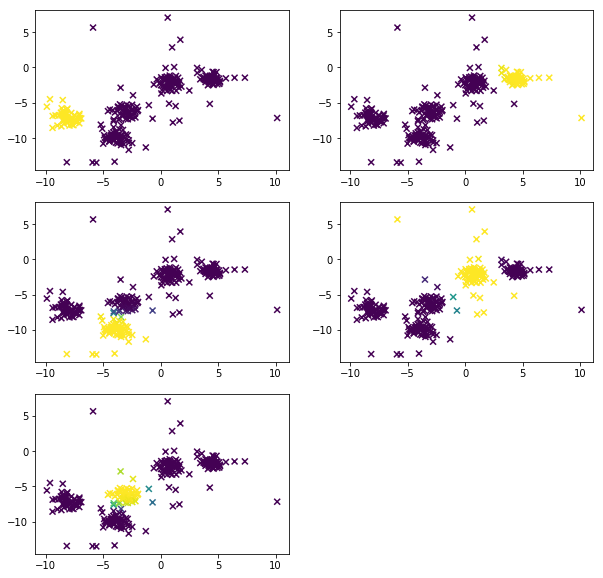

In [0]:
#plt.subplots(3,2,figsize=(8,6))
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_train[:,0],X_train[:,1],c=gm.predict_proba(X_train)[:,i],cmap='viridis',marker='x')

Our Mixture of Gaussians model is powerful! Not only is it unsupervised, it can both classify points into one of the K clusters we have, _and_ it can help us with our ultimate goal of identifying outlier points! We can do this by finding the points that no cluster wants to claim for itself.


In the cell below, calculate these values and then compute precision@k for k=1, 10, and 100.

* Is this model better or worse performing than the previous? 

Better
* Why might that be? 

In the previous model, a single gaussian distribution is applied to the 5 clusters of data. As a result, the model is only able to identify outliers when treating the 5 clusters as one, effectively missing out on the outliers that lay in between clusters. By using the Mixture of Gaussians model, a more complex model which is a combination of 5 gaussian distributions is generated. Together with the "score_samples" tool, it is possible to calculate the probability that a point is to have been generated by any of the 5 clusters, and whether it is an outlier. Therefore, the Mixture of Gaussians model is able to be more precise in terms of identifying outliers amongst the 5 clusters of data.

For a k of  1  the precision is  1.000  and the recall is  0.056
For a k of  10  the precision is  1.000  and the recall is  0.556
For a k of  100  the precision is  0.180  and the recall is  1.000


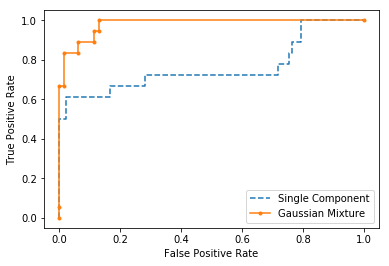

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#This part outputs the precision and recall on the test set

p_gm = gm.score_samples(X_test) #score_samples will compute the weighted log probabilities for each sample

for i in [1, 10, 100]: #Let's look at 3 different k values
   mn_gm = sorted(p_gm)[i] #We sort the points by probability, as before
   precision = precision_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
   recall = recall_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
   print('For a k of ',i,' the precision is ', '%.3f' % precision,' and the recall is ', '%.3f' % recall) #We print precision and recall three times

#This part computes the ROC curves for both models like we talked about in class

from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-p_gm)
pyplot.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()



Let's look at a dataset that motivates using a Mixture of Gaussians model: Simpsons ratings.

Everyone knows that there's a certain point when The Simpsons "got bad", but can we use a Mixture of Gaussians to find out exactly when that was?

Load up the `simpsons.pickle` file using the cell below. It contains the IMDb rating for every simpsons episode.

In [0]:
!wget https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
with open('simpsons.pickle','rb') as f:
    simpsons = pickle.load(f)

--2019-10-23 02:48:34--  https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle [following]
--2019-10-23 02:48:34--  https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26076 (25K) [application/octet-stream]
Saving to: ‘simpsons.pickle.2’

simpsons.pickle.2   100%[===================>]  25.46K  --.-KB/s    in 0.007s  

2019-10-23 02:48:34 (3.77 MB/s) - ‘simpsons.pickle.2’ saved [26076/26076]



With `plt.hist`, plot a histogram of the rating distribution for all Simpsons episodes. 

* What is the modal rating? 
7.3
* What is the range of ratings?

The range is from 4 to 9.3


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  8.,  0.,  1.,  1.,
         1.,  1.,  2.,  6., 11.,  4., 15., 18., 26., 17., 24., 37., 37.,
        33., 36., 40., 43., 27., 22., 11., 29., 24., 19., 18., 13., 24.,
        27., 19., 14., 11., 14.,  7.,  9.,  3.,  6.,  6.,  2.]),
 array([4.   , 4.106, 4.212, 4.318, 4.424, 4.53 , 4.636, 4.742, 4.848,
        4.954, 5.06 , 5.166, 5.272, 5.378, 5.484, 5.59 , 5.696, 5.802,
        5.908, 6.014, 6.12 , 6.226, 6.332, 6.438, 6.544, 6.65 , 6.756,
        6.862, 6.968, 7.074, 7.18 , 7.286, 7.392, 7.498, 7.604, 7.71 ,
        7.816, 7.922, 8.028, 8.134, 8.24 , 8.346, 8.452, 8.558, 8.664,
        8.77 , 8.876, 8.982, 9.088, 9.194, 9.3  ]),
 <a list of 50 Patch objects>)

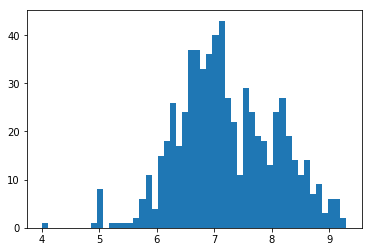

In [0]:
#Combining episode ratings
episodes = {}
for i in range(1,32): 
  episodes = {**episodes, **simpsons[i]}
plt.hist(episodes.values(),bins=50)



Next, use `sklearn.mixture.GaussianMixture` to fit a Mixture of Gaussians to the Simpsons rating distribution. Since we are trying to distinguish between good and bad ratings, we only need 2 gaussians.

* What are the means for the two Gaussians fit by the model? 

The mean is [[6.77369097]
 [8.17821488]]
* What about the standard deviations? 

The sigma is [[0.58870599]
 [0.47348044]]

In [0]:
# create array of ratings
ratings = []

for ep_name, ep_rating in episodes.items():
  ratings.append(ep_rating)
ratings = np.array(ratings).reshape(-1,1)

#initializing GassianMixture of 2
gm = GaussianMixture(n_components = 2,
  covariance_type = 'full', random_state=0, )
gm.fit(ratings)

#Compute means and std.dvs
ratings_means = gm.means_
ratings_stdv = np.sqrt(gm.covariances_)

print('The mean is' , ratings_means , ', and the sigma is', ratings_stdv)


The mean is [[6.77369097]
 [8.17821488]] , and the sigma is [[[0.58870599]]

 [[0.47348044]]]


Finally, using the `GaussianMixture.predict()` method, we can use maximum likelihood to estimate which distribution, good or bad, each episode belongs to. In the cell below, count the number of episodes predicted to be in the "good" distribution per season, and plot using `plt.plot`.

* Where is the notable drop-off point? 

Season 11, with 4 good episodes
* When is the first season with 0 good episodes? 

Season 15

Season  1
Number of good episodes:  9 

Season  2
Number of good episodes:  18 

Season  3
Number of good episodes:  24 

Season  4
Number of good episodes:  21 

Season  5
Number of good episodes:  21 

Season  6
Number of good episodes:  24 

Season  7
Number of good episodes:  24 

Season  8
Number of good episodes:  24 

Season  9
Number of good episodes:  20 

Season  10
Number of good episodes:  10 

Season  11
Number of good episodes:  4 

Season  12
Number of good episodes:  5 

Season  13
Number of good episodes:  4 

Season  14
Number of good episodes:  1 

Season  15
Number of good episodes:  0 

Season  16
Number of good episodes:  0 

Season  17
Number of good episodes:  0 

Season  18
Number of good episodes:  1 

Season  19
Number of good episodes:  1 

Season  20
Number of good episodes:  0 

Season  21
Number of good episodes:  0 

Season  22
Number of good episodes:  0 

Season  23
Number of good episodes:  2 

Season  24
Number of good episodes:  0 

Season  25
Numbe

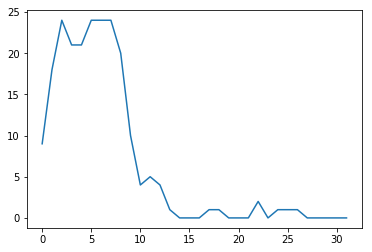

In [0]:
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))

# Count number of episodes with a predicted value of 1 in each season
count = []
for season, ep in simpsons.items():
  good_ep=0
  print('Season ',season)
  for ep_name, ep_ratings in ep.items():
    predict_ep_ratings = gm.predict(np.array(ep_ratings).reshape(-1,1))
    if predict_ep_ratings == [1]:
      good_ep += 1
  print('Number of good episodes: ', good_ep,'\n')
  count.append(good_ep)

# Plot number of good episodes in each season
plt.plot(count)
 




## Exercises

Now we are going to work with a credit card fraud dataset (more detail can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3)). This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load up the dataset using Pandas' `read_csv` function. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there?[1] 

284807
* What features in the dataset are present aside from the 28 main features?[1] 

‘Time' and 'Amount'
* Why do you think the main features are given to us in this way?[1] 

To protect user identity and sensitive features
* Which column contains the targets? Can you figure out what the values correspond to?[1] 

'Class' contains the targets, 1 for fraudulent transactions, 0 for non-fraudulent 

In [0]:
pip install wget

In [0]:
import wget
wget.download('https://github.com/alexwolson/APS1070_data/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar (2).gz'

In [0]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
creditcard = pd.read_csv("creditcard.csv") 
df = pd.DataFrame(creditcard)
print(df.shape)
df.head(10)

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


It's always important when looking at a new dataset to figure out how many rows we have for each class.

* What is the percentage of entries in the dataset for each class?[1] 

99.8% of entries for 'Class' are recorded as '0', 0.17% are recorded as '1'
* Why might this pose a problem with methods we have looked at so far?[1] 

The target data for fraudulent transactions is significantly less than that of its non-fraudulent counterpart. This might make it more difficult for the model to identify outliers (fraudulent data) since parameters of the outliers may not be well described by the gaussian distribution. It may require a large K to examine the performance of the model.


In [0]:
df['Class'].value_counts('1')


0    0.998273
1    0.001727
Name: Class, dtype: float64

Next, split the dataset into a training and testing set using sklearn's `train_test_split` function. Use a test size of one third, and set the random state to 0.

Make sure to separate out the column corresponding to the targets.

As mentioned earlier, in these exercises we are going to use Gaussian distributions to model the data. To accomplish this, we are going to introduce `scipy`, a package which contains a wide variety of tools for working with scientific data in Python. Its `stats` package allows us to easily model various statistical distributions, and get information about them.

Scipy's Gaussian distribution class is called `norm`. It takes two parameters - `loc`, which corresponds to the mean of your distribution, and `scale`, which corresponds to the standard deviation.

* What are the mean and standard deviation for variable V24? Make sure to only use your training set for this.[1] 

mean: 0.000294,
std: 0.36585

Use the code below to set up a Gaussian object for V24.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:30], df.iloc[:,30], test_size=0.33, random_state=0, shuffle=True)

In [0]:
from scipy import stats
import numpy as np

mean_v24 = sum(X_train['V24'])/len(X_train['V24'])
var_v24 = 1/len(X_train['V24']) * np.sum((X_train['V24']-mean_v24)**2,axis=0)

print('mean:',mean_v24,'\nstd:', var_v24**(1/2))

norm = stats.norm(mean_v24,var_v24**(1/2))
    


mean: 0.0002942484069872571 
std: 0.6048626021215933


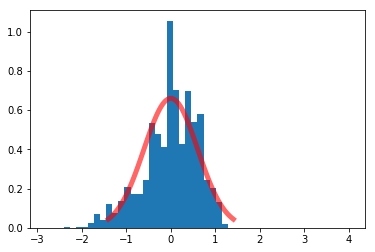

In [0]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(X_train['V24'].values, density=True, histtype='stepfilled', bins=50);
plt.show()

We can also look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

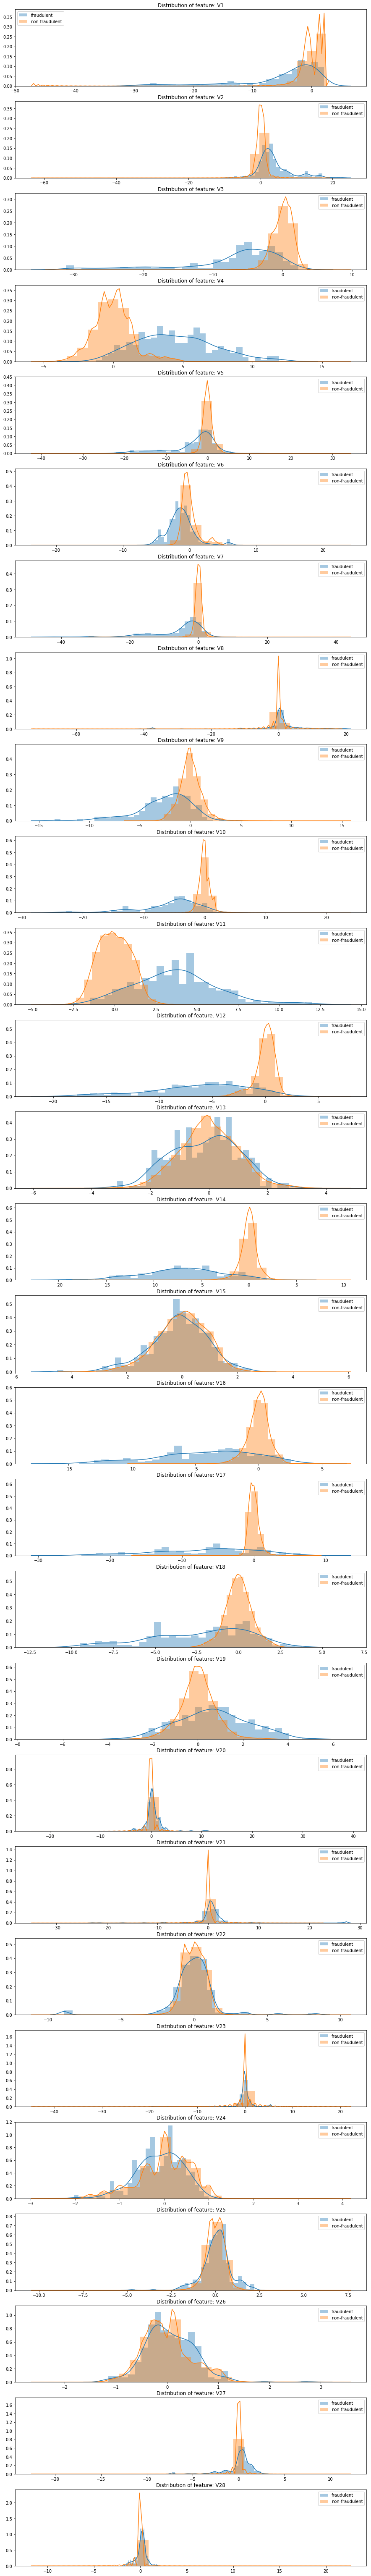

In [0]:
import matplotlib.gridspec as gridspec
import seaborn as sns
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train[feat][y_train==1], bins=30)
    sns.distplot(X_train[feat][y_train==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Build an outlier detection model using a Mixture of Gaussians using a subset of features of your choice (pick a few) and a number of mixture components. Report both the precision@k and recall@k for k=1, 10 and 100 (on test data). Repeat this model creation process at least 4 more times, each time selecting different parameters (features selected, number of mixture components), and reporting the precision and recall as above. Organize your findings in a table or plot and describe your findings. What can you conclude about what models work best? [3]

Based on the histogram distributions above, the features can be catagorized based on four characterizations: 

1. Overlapped distributions between fraudulent and non-fraudulent data (such as V15 and V13); 
2. Separated distributions between fraudulent and non-fraudulent data (such as V3 and V4); 
3. Widely-spread distribution of data (such as V11 and V12);
4. Narrowly-spread distribution of data (such as V20 and V21);

From each catagorization, one feature is chosen to form a set of 4 features. In addition, 4 different sets of features are formed. The goal is to obtain a variety of features that allows the model to be representative of the entire data set. 

For each feature set, the precision @k and recall @k are calculated for K values equal to 1, 10, and 100, also for the numbers of mixture components from 1 to 15. The results are presented in the tables below, each for one feature set. 

Based on the results presented in the tables, it should be noted that the precision and recall @K=1 values are zero for all 4 feature sets. This may be caused by the fact that the number of fraudulent data is very insignificant as compared to the number of non-fraudulent data, causing the model to perform poorly based on the prediction of only one data point. On the other hand, the precision and recall values for K equal to 10 and 100 are generally within expectations, with the precision decreasing and recall increasing as K increases. Out of the four feature sets, two feature sets have been observed to perform comparatively well: [V22, V12, V7, V14] and [V24, V16, V25, V17]. Precision values @K=10 is achieved equal or close to 1 for these two feature sets, with [V24, V16, V25, V17] achieving 1. 

Precision and recall values are plotted against the number of mixture components for K@10 and 100, as seen in the plots below. Based on the two well-performed feature sets, a general trend can be observed where the precision experiences a notable decline after a mixture component number of n=5, especially in the case of feature set [V24, V16, V25, V17]. This suggests that the dataset may be generally spread out into 5 cluster sets. 

Based on these findings, it can be concluded that the optimal model is achieved with the feature set [V24, V16, V25, V17], and a mixture component number of 5. 

In [0]:
import pandas as pd

print('Feature set: V13, V3, V6, V10')

# organize test findings in dataframe
df1 = pd.DataFrame()

for j in range(1,16): #testing with 1 to 15 components
  
  df1.loc[j-1,0] = str(j) #defining rows in DF
  
  from sklearn.mixture import GaussianMixture
  gm = GaussianMixture(n_components = j,
                    covariance_type = 'full', random_state=0, )
  gm.fit(X_train[['V13', 'V3', 'V6', 'V10']])

  from sklearn.metrics import precision_score
  from sklearn.metrics import recall_score

  #This part outputs the precision and recall on the test set

  p_gm = gm.score_samples(X_test[['V13', 'V3', 'V6', 'V10']]) #score_samples will compute the weighted log probabilities for each sample

  k = 1
  for i in [1, 10, 100]: #Let's look at 3 different k values
    
    mn_gm = sorted(p_gm)[i] #We sort the points by probability, as before
    precision = precision_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
    recall = recall_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
    
    df1.loc[j-1,k] = '%.3f' % precision #defining columns (alternating between Prec. and Rec.) in DF
    df1.loc[j-1,k+1] = '%.3f' % recall
    k += 2
    
df1.columns = ['Components(n)','Precision (K=1)','Recall (K=1)','Precision (K=10)','Recall (K=10)','Precision (K=100)','Recall (K=100)']
df1.iloc[:,1:6].astype(float)
df1
    

Feature set: V13, V3, V6, V10


,Components(n),Precision (K=1),Recall (K=1),Precision (K=10),Recall (K=10),Precision (K=100),Recall (K=100)
0,1,0.000,0.000,0.600,0.037,0.370,0.228
1,2,0.000,0.000,0.600,0.037,0.380,0.235
2,3,0.000,0.000,0.600,0.037,0.390,0.241
3,4,0.000,0.000,0.300,0.019,0.310,0.191
4,5,0.000,0.000,0.400,0.025,0.340,0.210
5,6,0.000,0.000,0.400,0.025,0.350,0.216
6,7,0.000,0.000,0.400,0.025,0.350,0.216
7,8,0.000,0.000,0.300,0.019,0.300,0.185
8,9,0.000,0.000,0.300,0.019,0.310,0.191
9,10,0.000,0.000,0.400,0.025,0.360,0.222


In [0]:
print('Feature set: V15, V4, V23, V11')

# organize test findings in dataframe
df2 = pd.DataFrame()

for j in range(1,16): #testing with 1 to 15 components
  
  df2.loc[j-1,0] = str(j) #defining rows in DF
  
  from sklearn.mixture import GaussianMixture
  gm = GaussianMixture(n_components = j,
                    covariance_type = 'full', random_state=0, )
  gm.fit(X_train[['V15', 'V4', 'V23', 'V11']])

  from sklearn.metrics import precision_score
  from sklearn.metrics import recall_score

  #This part outputs the precision and recall on the test set

  p_gm = gm.score_samples(X_test[['V15', 'V4', 'V23', 'V11']]) #score_samples will compute the weighted log probabilities for each sample

  k = 1
  for i in [1, 10, 100]: #Let's look at 3 different k values
    
    mn_gm = sorted(p_gm)[i] #We sort the points by probability, as before
    precision = precision_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
    recall = recall_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
    
    #defining columns (alternating between Prec. and Rec.) in DF
    df2.loc[j-1,k] = '%.3f' % precision 
    df2.loc[j-1,k+1] = '%.3f' % recall
    k += 2
    
df2.columns = ['Components(n)','Precision (K=1)','Recall (K=1)','Precision (K=10)','Recall (K=10)','Precision (K=100)','Recall (K=100)']
df2.iloc[:,1:6].astype(float)
df2

Feature set: V15, V4, V23, V11


,Components(n),Precision (K=1),Recall (K=1),Precision (K=10),Recall (K=10),Precision (K=100),Recall (K=100)
0,1,0.000,0.000,0.000,0.000,0.100,0.062
1,2,0.000,0.000,0.000,0.000,0.390,0.241
2,3,0.000,0.000,0.000,0.000,0.390,0.241
3,4,0.000,0.000,0.100,0.006,0.410,0.253
4,5,0.000,0.000,0.000,0.000,0.410,0.253
5,6,0.000,0.000,0.000,0.000,0.420,0.259
6,7,0.000,0.000,0.100,0.006,0.420,0.259
7,8,0.000,0.000,0.000,0.000,0.420,0.259
8,9,0.000,0.000,0.000,0.000,0.430,0.265
9,10,0.000,0.000,0.200,0.012,0.390,0.241


In [0]:
print('Feature set: V22, V12, V7, V14')

# organize test findings in dataframe
df3 = pd.DataFrame()

for j in range(1,16): #testing with 1 to 15 components
  
  df3.loc[j-1,0] = str(j) #defining rows in DF
  
  from sklearn.mixture import GaussianMixture
  gm = GaussianMixture(n_components = j,
                    covariance_type = 'full', random_state=0, )
  gm.fit(X_train[['V22', 'V12', 'V7', 'V14']])

  from sklearn.metrics import precision_score
  from sklearn.metrics import recall_score

  #This part outputs the precision and recall on the test set

  p_gm = gm.score_samples(X_test[['V22', 'V12', 'V7', 'V14']]) #score_samples will compute the weighted log probabilities for each sample

  k = 1
  for i in [1, 10, 100]: #Let's look at 3 different k values
    
    mn_gm = sorted(p_gm)[i] #We sort the points by probability, as before
    precision = precision_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
    recall = recall_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
    
    df3.loc[j-1,k] = '%.3f' % precision #defining columns (alternating between Prec. and Rec.) in DF
    df3.loc[j-1,k+1] = '%.3f' % recall
    k += 2
    
df3.columns = ['Components(n)','Precision (K=1)','Recall (K=1)','Precision (K=10)','Recall (K=10)','Precision (K=100)','Recall (K=100)']
df3.iloc[:,1:6].astype(float)
df3

Feature set: V22, V12, V7, V14


,Components(n),Precision (K=1),Recall (K=1),Precision (K=10),Recall (K=10),Precision (K=100),Recall (K=100)
0,1,0.000,0.000,0.700,0.043,0.510,0.315
1,2,0.000,0.000,0.700,0.043,0.500,0.309
2,3,0.000,0.000,0.800,0.049,0.480,0.296
3,4,0.000,0.000,0.800,0.049,0.480,0.296
4,5,0.000,0.000,0.700,0.043,0.500,0.309
5,6,0.000,0.000,0.200,0.012,0.330,0.204
6,7,0.000,0.000,0.300,0.019,0.400,0.247
7,8,0.000,0.000,0.200,0.012,0.330,0.204
8,9,0.000,0.000,0.100,0.006,0.330,0.204
9,10,0.000,0.000,0.100,0.006,0.330,0.204


In [0]:
print('Feature set: V24, V16, V25, V17')

# organize test findings in dataframe
df4 = pd.DataFrame()

for j in range(1,16): #testing with 1 to 15 components
  
  df4.loc[j-1,0] = str(j) #defining rows in DF
  
  from sklearn.mixture import GaussianMixture
  gm = GaussianMixture(n_components = j,
                    covariance_type = 'full', random_state=0, )
  gm.fit(X_train[['V24', 'V16', 'V25', 'V17']])

  from sklearn.metrics import precision_score
  from sklearn.metrics import recall_score

  #This part outputs the precision and recall on the test set

  p_gm = gm.score_samples(X_test[['V24', 'V16', 'V25', 'V17']]) #score_samples will compute the weighted log probabilities for each sample

  k = 1
  for i in [1, 10, 100]: #Let's look at 3 different k values
    
    mn_gm = sorted(p_gm)[i] #We sort the points by probability, as before
    precision = precision_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
    recall = recall_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
    
    df4.loc[j-1,k] = '%.3f' % precision #defining columns (alternating between Prec. and Rec.) in DF
    df4.loc[j-1,k+1] = '%.3f' % recall
    k += 2
    
df4.columns = ['Components(n)','Precision (K=1)','Recall (K=1)','Precision (K=10)','Recall (K=10)','Precision (K=100)','Recall (K=100)']
df4.iloc[:,1:6].astype(float)
df4

Feature set: V24, V16, V25, V17


,Components(n),Precision (K=1),Recall (K=1),Precision (K=10),Recall (K=10),Precision (K=100),Recall (K=100)
0,1,1.000,0.006,1.000,0.062,0.700,0.432
1,2,0.000,0.000,0.900,0.056,0.620,0.383
2,3,0.000,0.000,0.900,0.056,0.510,0.315
3,4,0.000,0.000,0.200,0.012,0.330,0.204
4,5,0.000,0.000,0.000,0.000,0.260,0.160
5,6,0.000,0.000,0.000,0.000,0.230,0.142
6,7,0.000,0.000,0.000,0.000,0.240,0.148
7,8,0.000,0.000,0.100,0.006,0.260,0.160
8,9,0.000,0.000,0.000,0.000,0.230,0.142
9,10,0.000,0.000,0.000,0.000,0.230,0.142


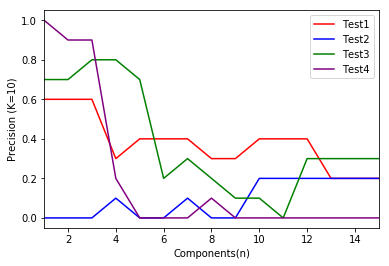

In [0]:
# Plot for Precision (K=10)
import matplotlib.pyplot as plt

ax = plt.gca()
df1=df1.astype(float)
df2=df2.astype(float)
df3=df3.astype(float)
df4=df4.astype(float)
df1.plot(kind='line', x='Components(n)', y='Precision (K=10)', color='red', label='Test1', ax=ax)
df2.plot(kind='line', x='Components(n)', y='Precision (K=10)', color='blue', label='Test2', ax=ax)
df3.plot(kind='line', x='Components(n)', y='Precision (K=10)', color='green', label='Test3', ax=ax)
df4.plot(kind='line', x='Components(n)', y='Precision (K=10)', color='purple', label='Test4', ax=ax)
pyplot.xlabel('Components(n)')
pyplot.ylabel('Precision (K=10)')
plt.show()

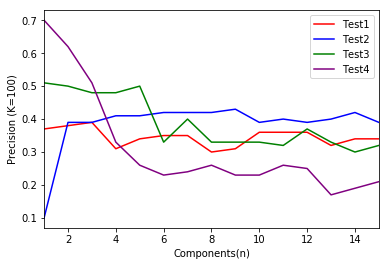

In [0]:
# Plot for Precision (K=100)
import matplotlib.pyplot as plt

ax = plt.gca()
df1.plot(kind='line', x='Components(n)', y='Precision (K=100)', color='red', label='Test1', ax=ax)
df2.plot(kind='line', x='Components(n)', y='Precision (K=100)', color='blue', label='Test2', ax=ax)
df3.plot(kind='line', x='Components(n)', y='Precision (K=100)', color='green', label='Test3', ax=ax)
df4.plot(kind='line', x='Components(n)', y='Precision (K=100)', color='purple', label='Test4', ax=ax)
pyplot.xlabel('Components(n)')
pyplot.ylabel('Precision (K=100)')
plt.show()

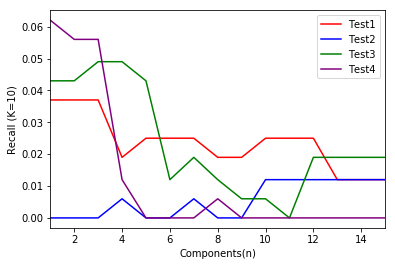

In [0]:
# Plot for Recall (K=10)
import matplotlib.pyplot as plt

ax = plt.gca()
df1.plot(kind='line', x='Components(n)', y='Recall (K=10)', color='red', label='Test1', ax=ax)
df2.plot(kind='line', x='Components(n)', y='Recall (K=10)', color='blue', label='Test2', ax=ax)
df3.plot(kind='line', x='Components(n)', y='Recall (K=10)', color='green', label='Test3', ax=ax)
df4.plot(kind='line', x='Components(n)', y='Recall (K=10)', color='purple', label='Test4', ax=ax)
pyplot.xlabel('Components(n)')
pyplot.ylabel('Recall (K=10)')
plt.show()

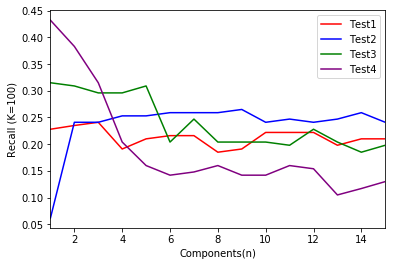

In [0]:
# Plot for Recall (K=100)
import matplotlib.pyplot as plt

ax = plt.gca()
df1.plot(kind='line', x='Components(n)', y='Recall (K=100)', color='red', label='Test1', ax=ax)
df2.plot(kind='line', x='Components(n)', y='Recall (K=100)', color='blue', label='Test2', ax=ax)
df3.plot(kind='line', x='Components(n)', y='Recall (K=100)', color='green', label='Test3', ax=ax)
df4.plot(kind='line', x='Components(n)', y='Recall (K=100)', color='purple', label='Test4', ax=ax)
pyplot.xlabel('Components(n)')
pyplot.ylabel('Recall (K=100)')
plt.show()